In [57]:
import io
from datetime import datetime
import datetime
from scipy.sparse import coo_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pylab import rcParams
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE, RFECV

from yellowbrick.model_selection import ValidationCurve
from sklearn.tree import DecisionTreeClassifier
import math
import holidays
from datetime import date
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import explained_variance_score
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import RepeatedKFold, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARMA,ARIMA
import warnings
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pylab import rcParams
import statsmodels.api as sm
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)



# Ratp Notice
Air quality at Châtelet subway station (2013-2020) from data.ratp.fr:
https://data.ratp.fr/explore/dataset/qualite-de-lair-mesuree-dans-la-station-chatele
Colonne Description
*  DATE Date et heure de la mesure exprimé en Temps Universel
(L’heure réelle peut être TU+1 ou TU+2 suivant l’heure d’été ou d’hiver.)
* HEURE Heure de la mesure
* NO Concentration moyenne en NO en µg/m3
* NO2 Concentration moyenne en NO2 en µg/m3
* PM10 Concentration moyenne en PM10 en µg/m3
* CO2 Concentration moyenne en CO2 en ppm
* TEMP Température ambiante en °C
* HUMI Humidité relative en %

## Objective:
- predict gas levels based on the concentrations of other gases and time of the day, etc.. (features).
- Forcasting gases concentration (time series)
* This notebook will focus on CO2 concentration prediction

In [3]:
ratp_chatelet = pd.read_csv('https://raw.githubusercontent.com/sh1r4/ratp_dataset/main/qualite-de-lair-mesuree-dans-la-station-chatelet.csv', 
delimiter=';')

In [4]:
ratp_chatelet.head(5)

,DATE/HEURE,NO,NO2,PM10,CO2,TEMP,HUMI
0,2013-03-04T16:00:00+01:00,38.0,62.0,128.0,777.0,17.2,40.4
1,2013-03-04T20:00:00+01:00,51.0,75.0,136.0,843.0,17.8,44.9
2,2013-03-05T22:00:00+01:00,57.0,70.0,149.0,626.0,19.1,38.5
3,2013-03-06T10:00:00+01:00,171.0,94.0,150.0,800.0,18.5,39.0
4,2013-03-08T21:00:00+01:00,31.0,61.0,105.0,800.0,19.9,54.2


In [5]:
print("Chatelet station Data : {0}".format(ratp_chatelet.shape))

Chatelet station Data : (68629, 7)


In [6]:
ratp_chatelet.isnull().sum()

DATE/HEURE        0
NO            26713
NO2           17027
PM10          14701
CO2           15032
TEMP          10591
HUMI          10590
dtype: int64

The amount of missing data is large ~(25% to 35%) in multiple columns.


## Data column (Feature extraction)

Extract useful info from the date (pollution level is affected by the number of metros), so it is important to identify:
- Weekends
- Holidays
- Time of the day.
- Also, it might be useful to look at the month and hour of the day.


In [7]:
ratp_chatelet['DATE/HEURE_Datetime'] = pd.to_datetime(ratp_chatelet['DATE/HEURE'],utc=True)

In [8]:
def isweekend(day_no):
    if (int(day_no)>4):
        return 1
    else:
        return 0

In [9]:
def isweekend(day_no):
    if (int(day_no)>4):
        return 1
    else:
        return 0

In [10]:
def timeofday(hour):
    if (hour>=0 and hour<=8):
        return 'Midnight'
    if (hour>8 and hour<=12):
        return 'Morning'
    if (hour>12 and hour<=16):
        return 'Afternoon'
    if (hour>16 and hour<=20):
        return 'Evening'
    if (hour>20):
        return 'Night'

In [11]:
datasets = [ratp_chatelet]
fr_holidays = holidays.France()

for j in datasets:
    j['Year'] = j['DATE/HEURE_Datetime'].dt.year
    j['Month'] = j['DATE/HEURE_Datetime'].dt.month
    j['Day'] = j['DATE/HEURE_Datetime'].dt.day
    j['Hour'] = j['DATE/HEURE_Datetime'].dt.hour
    j['Weekday'] = j['DATE/HEURE_Datetime'].dt.weekday
    j['isWeekend'] = j['Weekday'].apply(lambda x : isweekend(x))
    j['isHoliday'] = j['DATE/HEURE_Datetime'].dt.date.apply(lambda x: x in fr_holidays)
    j['isHoliday'] = j['isHoliday'].astype(int)
    j['TimeOfDay'] = j['Hour'].apply(lambda x: timeofday(x))



In [12]:
ratp_chatelet.head(5)

,DATE/HEURE,NO,NO2,PM10,CO2,TEMP,HUMI,DATE/HEURE_Datetime,Year,Month,Day,Hour,Weekday,isWeekend,isHoliday,TimeOfDay
0,2013-03-04T16:00:00+01:00,38.0,62.0,128.0,777.0,17.2,40.4,2013-03-04 15:00:00+00:00,2013,3,4,15,0,0,0,Afternoon
1,2013-03-04T20:00:00+01:00,51.0,75.0,136.0,843.0,17.8,44.9,2013-03-04 19:00:00+00:00,2013,3,4,19,0,0,0,Evening
2,2013-03-05T22:00:00+01:00,57.0,70.0,149.0,626.0,19.1,38.5,2013-03-05 21:00:00+00:00,2013,3,5,21,1,0,0,Night
3,2013-03-06T10:00:00+01:00,171.0,94.0,150.0,800.0,18.5,39.0,2013-03-06 09:00:00+00:00,2013,3,6,9,2,0,0,Morning
4,2013-03-08T21:00:00+01:00,31.0,61.0,105.0,800.0,19.9,54.2,2013-03-08 20:00:00+00:00,2013,3,8,20,4,0,0,Evening


## Data Analysis

In [13]:
ratp_chatelet_copy = ratp_chatelet.copy()
ratp_chatelet_copy = ratp_chatelet_copy[['DATE/HEURE_Datetime', 'NO', 'NO2', 'PM10', 'CO2', 'TEMP','HUMI']]


In [14]:
ratp_chatelet_copy = ratp_chatelet_copy.set_index('DATE/HEURE_Datetime')
ratp_chatelet_copy.index = pd.to_datetime(ratp_chatelet_copy.index)
ratp_chatelet_copy = ratp_chatelet_copy.sort_index()


years = [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]

In [15]:
cols = ratp_chatelet_copy.columns.to_list()
cols2 = ratp_chatelet_copy.columns.to_list()


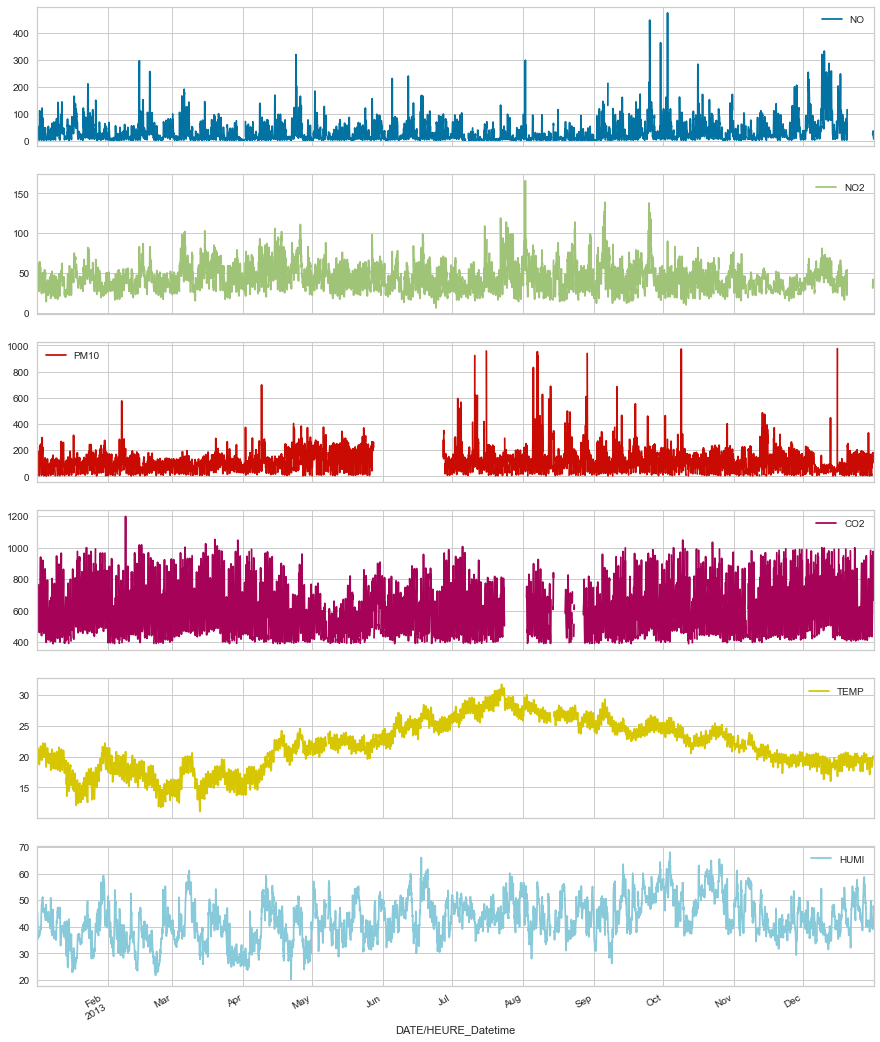

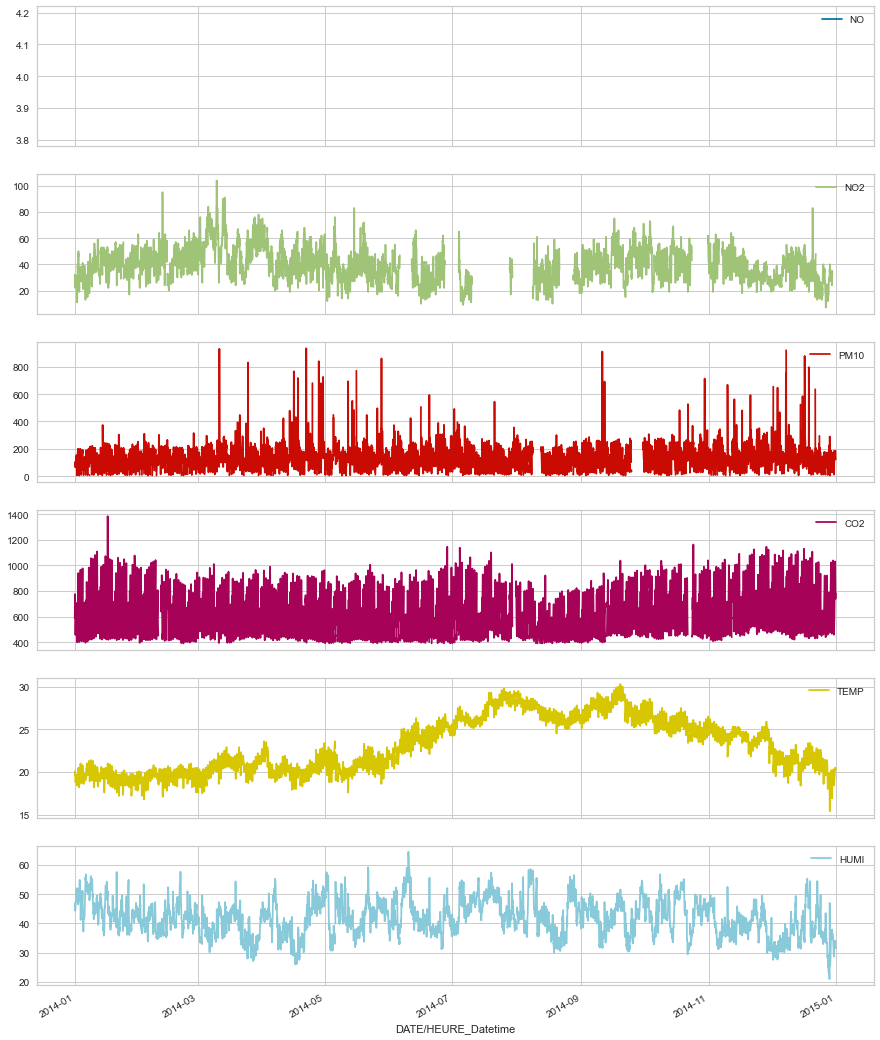

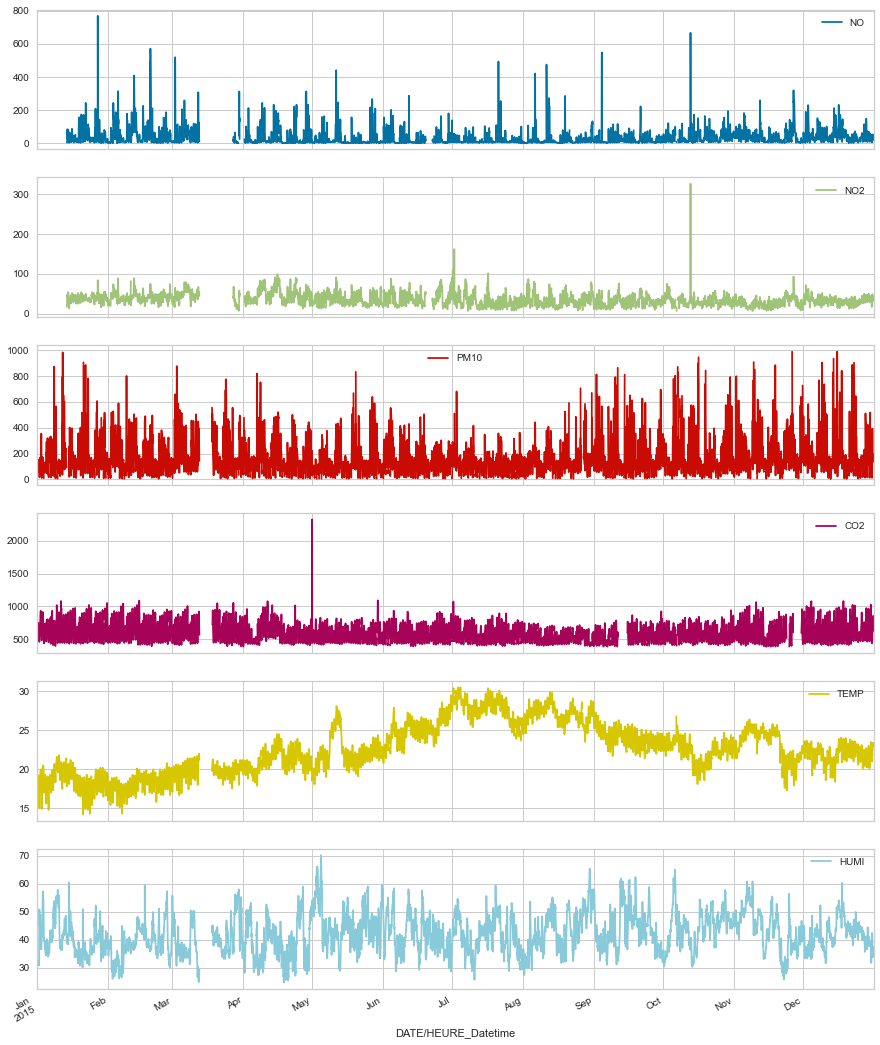

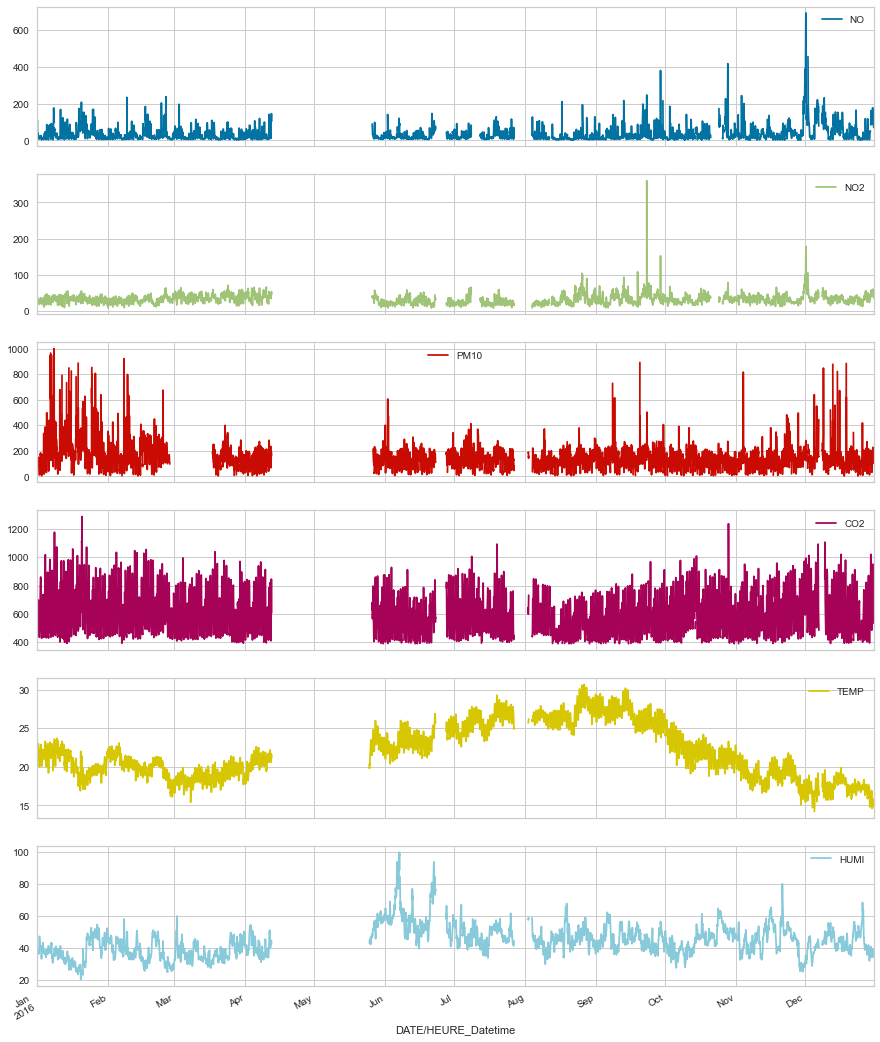

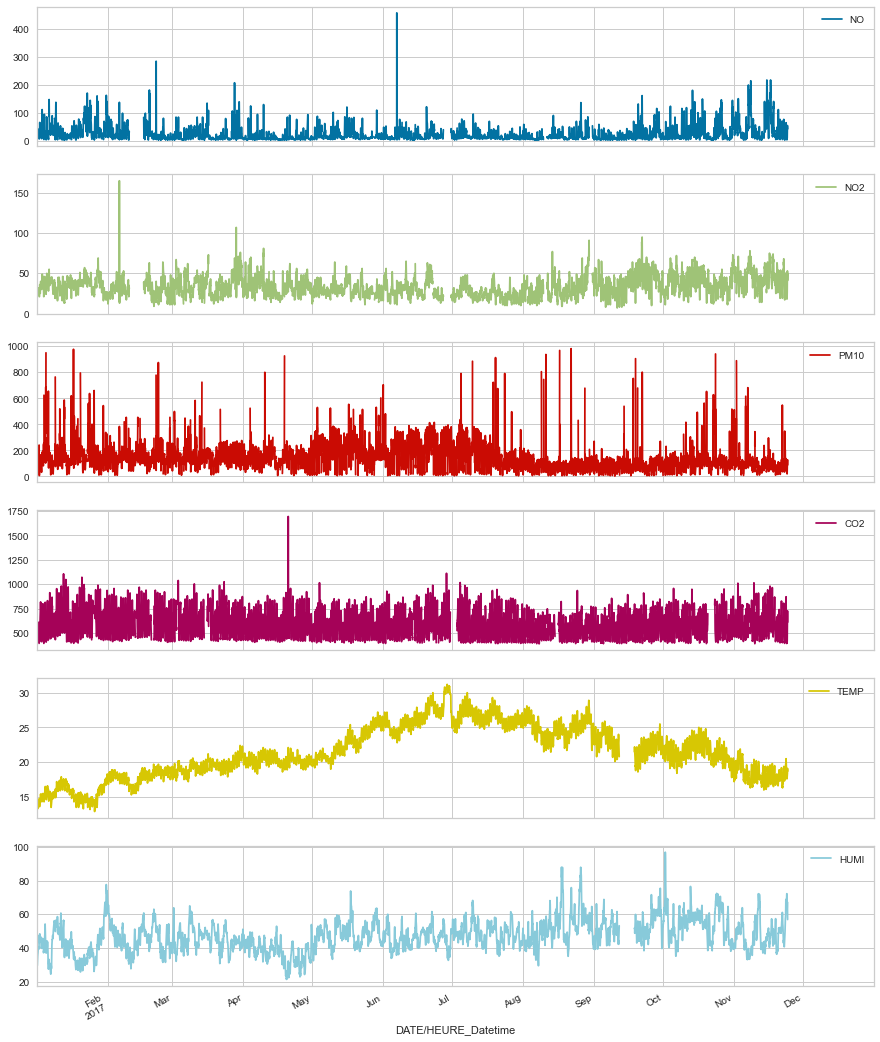

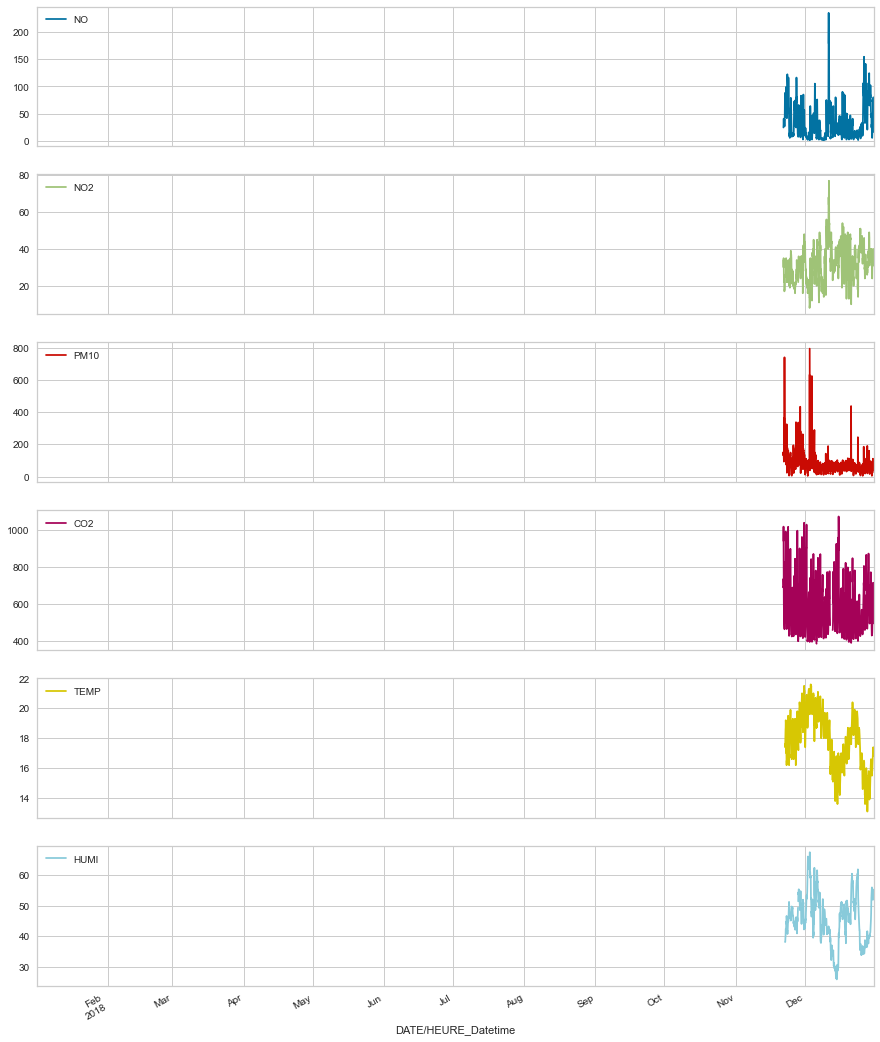

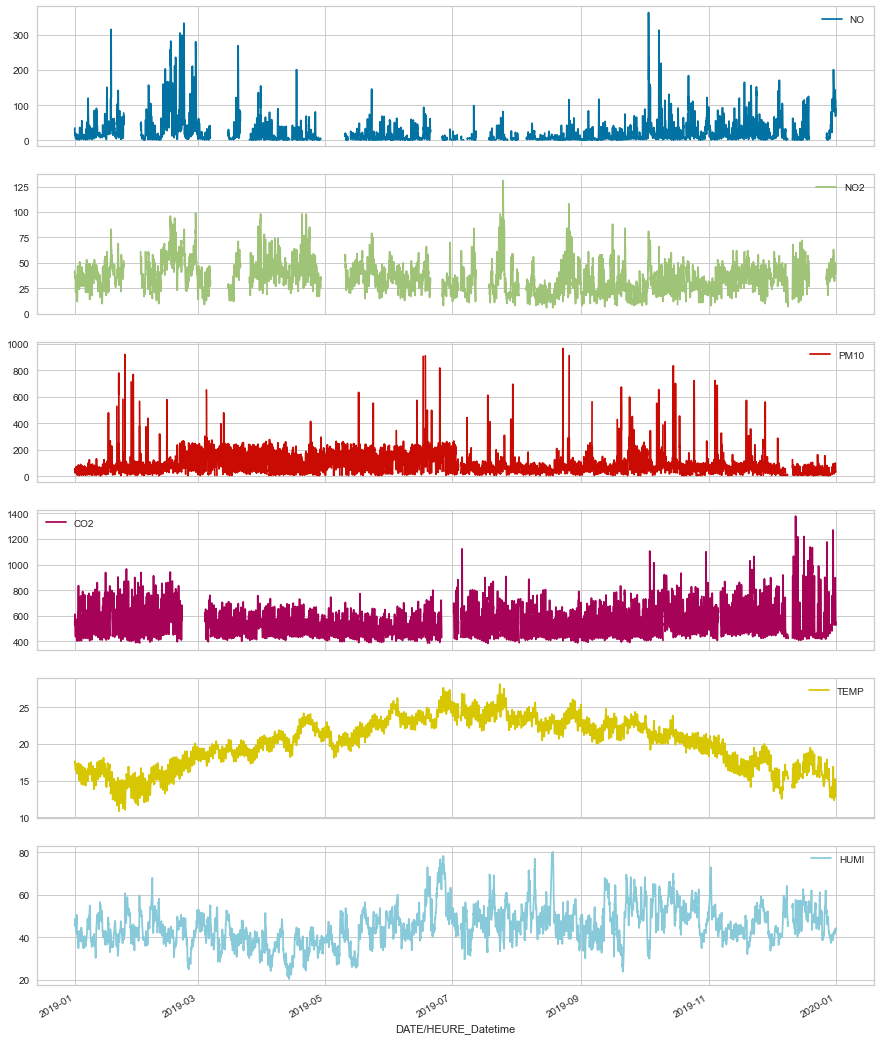

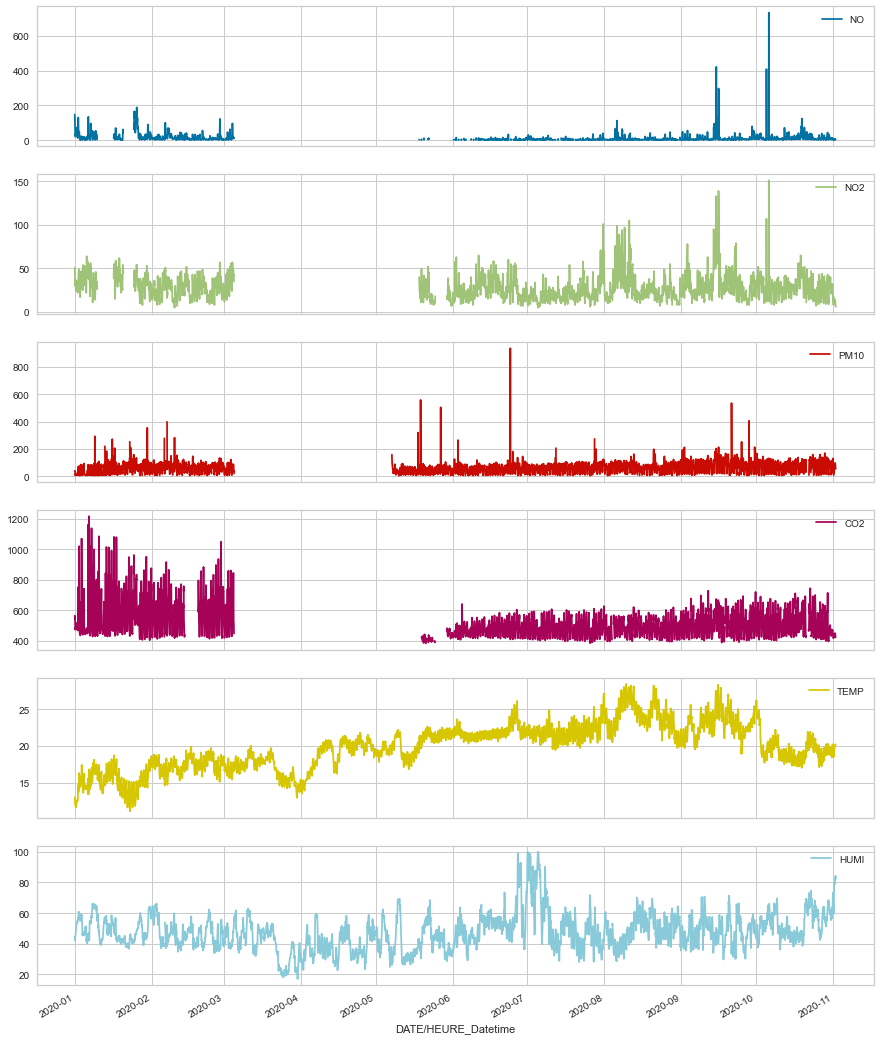

In [16]:
for year in years:
    ratp_chatelet_copy[str(year)][cols].plot(subplots=True, figsize=(15, 20))

Missing data :
- In year 2014 NO level gas readings are fully missing
- In 2016, between Apr and Jun there is a gap in data in all gases.
- From 2017 Dec to 2018 mid Nov data is missing.
- During lookdown (March to May) gases data is not recorded.

### Validating the Statinarity of the data

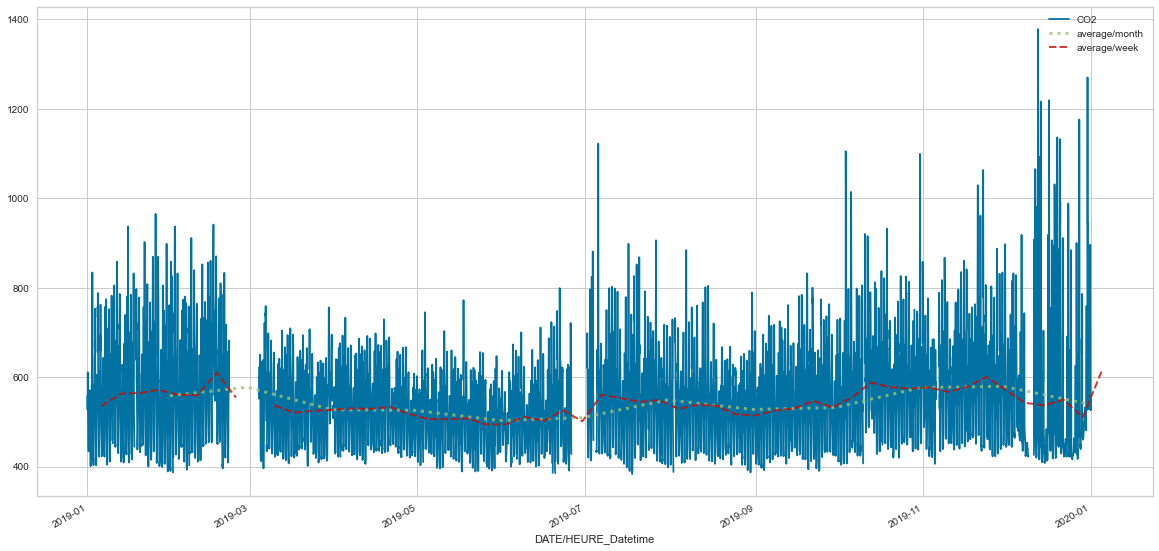

In [17]:
plt.figure(figsize=(20, 10))
ratp_chatelet_copy.loc['2019', 'CO2'].plot()
ratp_chatelet_copy.loc['2019', 'CO2'].resample('M').mean().plot(label='average/month', lw=3, ls=':', alpha=0.8)
ratp_chatelet_copy.loc['2019', 'CO2'].resample('W').mean().plot(label='average/week', lw=2, ls='--', alpha=0.8)
plt.legend()
plt.show()

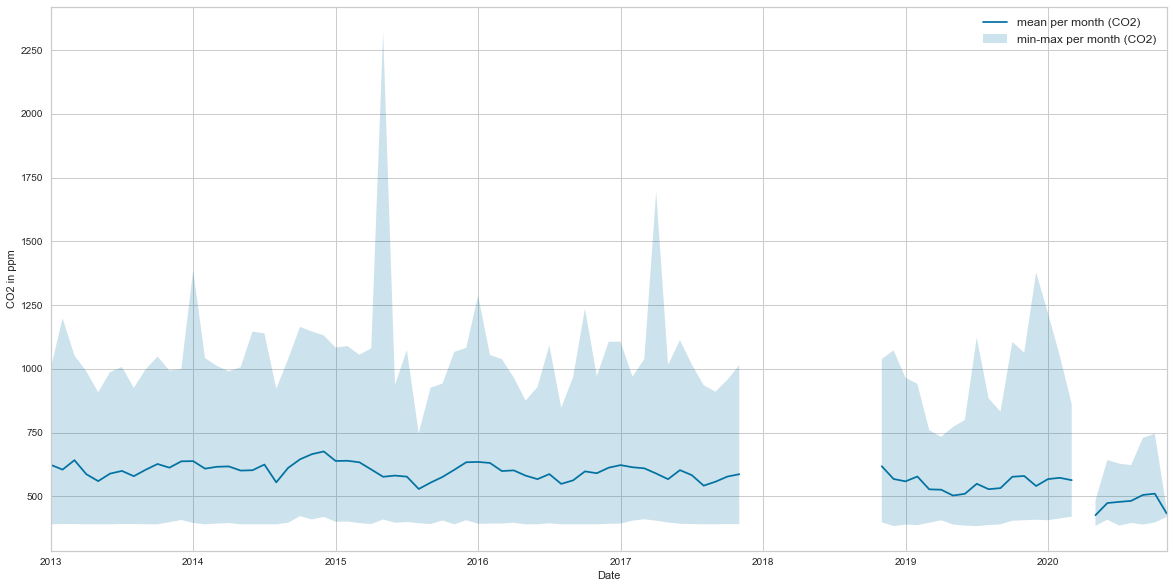

In [18]:


m = ratp_chatelet_copy.loc['2013':'2020', 'CO2'].resample('M').agg(['mean', 'std', 'min', 'max'])

plt.figure(figsize=(20, 10))
m['mean']['2013':'2020'].plot(label='mean per month (CO2)')
plt.fill_between(m.index, m['max'], m['min'], alpha=0.2, label='min-max per month (CO2)')
plt.xlabel('Date')
plt.ylabel('CO2 in ppm')
plt.legend(fontsize='medium')
plt.show()

From examining CO2 levels it can be seen that CO2 data is stationary, however, it is better to test it formally and with all the parameters.

### Augmented Dickey-Fuller test

In [19]:
ratp_chatelet_copy.columns

Index(['NO', 'NO2', 'PM10', 'CO2', 'TEMP', 'HUMI'], dtype='object')

In [20]:
para_to_test = ['NO', 'NO2', 'PM10', 'CO2', 'TEMP', 'HUMI']
for col in para_to_test:
    para = ratp_chatelet_copy[col].dropna().values
    result = adfuller(para)
    print(col)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    print('-----------------------------------------------')

NO
ADF Statistic: -19.895596
p-value: 0.000000
	1%: -3.431
	5%: -2.862
	10%: -2.567
-----------------------------------------------
NO2
ADF Statistic: -18.374672
p-value: 0.000000
	1%: -3.430
	5%: -2.862
	10%: -2.567
-----------------------------------------------
PM10
ADF Statistic: -16.038036
p-value: 0.000000
	1%: -3.430
	5%: -2.862
	10%: -2.567
-----------------------------------------------
CO2
ADF Statistic: -14.424576
p-value: 0.000000
	1%: -3.430
	5%: -2.862
	10%: -2.567
-----------------------------------------------
TEMP
ADF Statistic: -4.724417
p-value: 0.000076
	1%: -3.430
	5%: -2.862
	10%: -2.567
-----------------------------------------------
HUMI
ADF Statistic: -15.977390
p-value: 0.000000
	1%: -3.430
	5%: -2.862
	10%: -2.567
-----------------------------------------------


Since p-value is less than 0.05, also ADF statistic is less the 1% this lead to rejecting the null hypothesis and it means data is stationary and need to do any transformation

## Correlation between variables

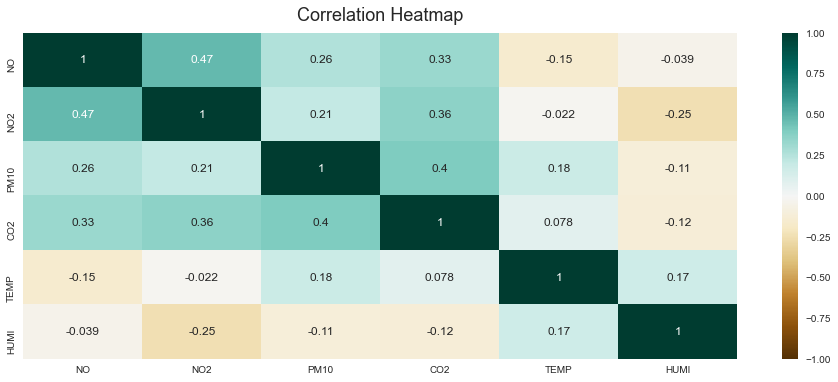

In [21]:
import seaborn as sns
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(ratp_chatelet_copy.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);



- the strongest correlation is between NO2 and NO which is logical.
- all the gases are correlated with CO2 by a weak correlation.


## Dealing Missing Values and outliers
- Since more than 25% of the data is missing in different places and going with just replacing with general mean/median can really affect the data, I went with replacing missing values/outliers as the following:
- if there are some data points missing during the day --> replace with mean of the values that correspond to the time of the day (evenning, morning,...)
- if data is not available for the day --> look for the day before or after and follow as the step before.
- if data is not available during the day nor the day before or after look at the same time of the year in previous years with similar temp and humi then replace with mean of the corresponding period of the d

In [22]:
ratp_chatelet.head()

,DATE/HEURE,NO,NO2,PM10,CO2,TEMP,HUMI,DATE/HEURE_Datetime,Year,Month,Day,Hour,Weekday,isWeekend,isHoliday,TimeOfDay
0,2013-03-04T16:00:00+01:00,38.0,62.0,128.0,777.0,17.2,40.4,2013-03-04 15:00:00+00:00,2013,3,4,15,0,0,0,Afternoon
1,2013-03-04T20:00:00+01:00,51.0,75.0,136.0,843.0,17.8,44.9,2013-03-04 19:00:00+00:00,2013,3,4,19,0,0,0,Evening
2,2013-03-05T22:00:00+01:00,57.0,70.0,149.0,626.0,19.1,38.5,2013-03-05 21:00:00+00:00,2013,3,5,21,1,0,0,Night
3,2013-03-06T10:00:00+01:00,171.0,94.0,150.0,800.0,18.5,39.0,2013-03-06 09:00:00+00:00,2013,3,6,9,2,0,0,Morning
4,2013-03-08T21:00:00+01:00,31.0,61.0,105.0,800.0,19.9,54.2,2013-03-08 20:00:00+00:00,2013,3,8,20,4,0,0,Evening


In [23]:
ratp_chatelet.shape
ratp_chatelet = ratp_chatelet.dropna(subset=[ 'NO', 'NO2', 'PM10', 'CO2', 'TEMP','HUMI'], thresh=5)
ratp_chatelet = ratp_chatelet.reset_index().drop(columns={'index'})

In [24]:
def outliers_missing_values_replacing(dataframe,point,column):
    if ((dataframe[dataframe['Day']==point['Day']][column]).shape[0]>0):
            temp = dataframe[dataframe['Day']==point['Day']]
            if ((dataframe[dataframe['TimeOfDay']==point['TimeOfDay']][column]).shape[0]>0):
                temp = temp[temp['TimeOfDay']==point['TimeOfDay']]
                return temp[column].mean()
            else:
                return temp[column].mean()
    elif((dataframe[dataframe['Day']== (point['Day']-1)][column]).shape[0]>0):
        temp = dataframe[dataframe['Day']==(point['Day']-1)]
        if ((dataframe[dataframe['TimeOfDay']==point['TimeOfDay']][column]).shape[0]>0):
            temp = temp[temp['TimeOfDay']==point['TimeOfDay']]
            return temp[column].mean()
        else:
            return temp[column].mean()
    elif((dataframe[dataframe['Day']== (point['Day']+1)][column]).shape[0]>0):  
        temp = dataframe[dataframe['Day']==(point['Day']+1)]
        if ((dataframe[dataframe['TimeOfDay']==point['TimeOfDay']][column]).shape[0]>0):
            temp = temp[temp['TimeOfDay']==point['TimeOfDay']]
            return temp[column].mean()
        else:
            return temp[column].mean()
    elif((dataframe[dataframe['Year']== point['Year']][column]).shape[0]>0):
            temp = dataframe[dataframe['Year']==point['Year']]
            temp = temp[temp['isWeekend']==point['isWeekend']]
            tmp = point['TEMP']
            hum = point['HUMI']
            temp = temp[(tmp-2<temp['TEMP'])(temp['TEMP']<tmp+2)]
            temp = temp[(hum-10<temp['HUMI'])(temp['HUMI']<hum+10)]
            

### Outliers
The data is recorded through sensors, so there is a possibilities that sensor readings may overshot or have some problems

In [25]:
def identify_Outliers(dataframe,column):
    q1= dataframe[column].quantile(.25)
    q3= dataframe[column].quantile(.75)
    iqr = q3-q1
    lower = q1-(1.5*iqr)
    upper = q3+(1.5*iqr)
    outliers = dataframe[(dataframe[column]<lower) | (dataframe[column]>upper)]
    return outliers

In [26]:
column_create = ['CO2_repl','NO2_repl','NO_repl','PM10_repl']
column_create_check = ['CO2','NO2','NO','PM10']

<AxesSubplot:>

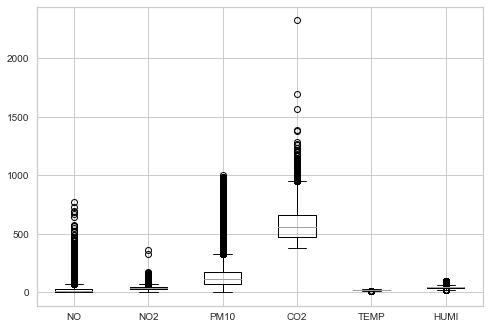

In [27]:
ratp_chatelet.boxplot(column=['NO', 'NO2', 'PM10', 'CO2', 'TEMP', 'HUMI'])

From the boxplots it is clear that data contain outliers

<AxesSubplot:>

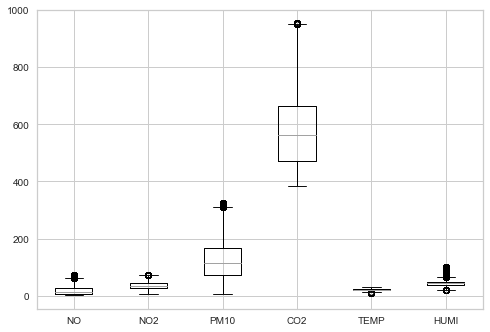

In [28]:
data = ratp_chatelet
for creat_column,column in zip (column_create,column_create_check):
        data[creat_column]=identify_Outliers(data,column).apply(lambda x:outliers_missing_values_replacing(data,x,column), axis=1)
        data[creat_column].fillna(data[column], inplace=True)
        data[column] = data[creat_column]


ratp_chatelet = ratp_chatelet.drop(columns={'CO2_repl','NO2_repl','NO_repl','PM10_repl'})
ratp_chatelet.boxplot(column=['NO', 'NO2', 'PM10', 'CO2', 'TEMP', 'HUMI'])

### Missing values

In [29]:
ratp_chatelet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50354 entries, 0 to 50353
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   DATE/HEURE           50354 non-null  object             
 1   NO                   41573 non-null  float64            
 2   NO2                  50354 non-null  float64            
 3   PM10                 48444 non-null  float64            
 4   CO2                  48532 non-null  float64            
 5   TEMP                 50354 non-null  float64            
 6   HUMI                 50345 non-null  float64            
 7   DATE/HEURE_Datetime  50354 non-null  datetime64[ns, UTC]
 8   Year                 50354 non-null  int64              
 9   Month                50354 non-null  int64              
 10  Day                  50354 non-null  int64              
 11  Hour                 50354 non-null  int64              
 12  Weekday           

In [30]:
ratp_chatelet['CO2_repl'] = ratp_chatelet[ratp_chatelet['CO2'].isna()].apply(lambda x:outliers_missing_values_replacing(ratp_chatelet,x,'CO2'), axis=1 )
ratp_chatelet['NO_repl'] = ratp_chatelet[ratp_chatelet['NO'].isna()].apply(lambda x:outliers_missing_values_replacing(ratp_chatelet,x,'NO'), axis=1 )
ratp_chatelet['PM10_repl'] = ratp_chatelet[ratp_chatelet['PM10'].isna()].apply(lambda x:outliers_missing_values_replacing(ratp_chatelet,x,'PM10'), axis=1 )
ratp_chatelet.CO2.fillna(ratp_chatelet.CO2_repl, inplace=True)
ratp_chatelet.NO.fillna(ratp_chatelet.NO_repl, inplace=True)
ratp_chatelet.PM10.fillna(ratp_chatelet.PM10_repl, inplace=True)

In [31]:
ratp_chatelet = ratp_chatelet.drop(columns={'CO2_repl','NO_repl','PM10_repl'})

In [32]:
ratp_chatelet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50354 entries, 0 to 50353
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   DATE/HEURE           50354 non-null  object             
 1   NO                   50354 non-null  float64            
 2   NO2                  50354 non-null  float64            
 3   PM10                 50354 non-null  float64            
 4   CO2                  50354 non-null  float64            
 5   TEMP                 50354 non-null  float64            
 6   HUMI                 50345 non-null  float64            
 7   DATE/HEURE_Datetime  50354 non-null  datetime64[ns, UTC]
 8   Year                 50354 non-null  int64              
 9   Month                50354 non-null  int64              
 10  Day                  50354 non-null  int64              
 11  Hour                 50354 non-null  int64              
 12  Weekday           

## Standarization

In [33]:
ratp_chatelet.head()

,DATE/HEURE,NO,NO2,PM10,CO2,TEMP,HUMI,DATE/HEURE_Datetime,Year,Month,Day,Hour,Weekday,isWeekend,isHoliday,TimeOfDay
0,2013-03-04T16:00:00+01:00,38.000000,62.000000,128.0,777.0,17.2,40.4,2013-03-04 15:00:00+00:00,2013,3,4,15,0,0,0,Afternoon
1,2013-03-04T20:00:00+01:00,51.000000,40.077703,136.0,843.0,17.8,44.9,2013-03-04 19:00:00+00:00,2013,3,4,19,0,0,0,Evening
2,2013-03-05T22:00:00+01:00,57.000000,70.000000,149.0,626.0,19.1,38.5,2013-03-05 21:00:00+00:00,2013,3,5,21,1,0,0,Night
3,2013-03-06T10:00:00+01:00,42.786008,39.557895,150.0,800.0,18.5,39.0,2013-03-06 09:00:00+00:00,2013,3,6,9,2,0,0,Morning
4,2013-03-08T21:00:00+01:00,31.000000,61.000000,105.0,800.0,19.9,54.2,2013-03-08 20:00:00+00:00,2013,3,8,20,4,0,0,Evening


In [34]:

columns=['NO', 'NO2', 'PM10', 'CO2', 'TEMP', 'HUMI',
        'Year', 'Month', 'Day', 'Hour', 'Weekday']

for i in  columns:
        scale = StandardScaler().fit(ratp_chatelet[[i]])
        ratp_chatelet[i] = scale.transform(ratp_chatelet[[i]])
        

In [35]:
ratp_chatelet.head()

,DATE/HEURE,NO,NO2,PM10,CO2,TEMP,HUMI,DATE/HEURE_Datetime,Year,Month,Day,Hour,Weekday,isWeekend,isHoliday,TimeOfDay
0,2013-03-04T16:00:00+01:00,1.190950,2.064086,0.084379,1.582640,-1.251864,-0.439143,2013-03-04 15:00:00+00:00,-1.352406,-1.026933,-1.307258,0.489601,-1.499455,0,0,Afternoon
1,2013-03-04T20:00:00+01:00,2.038558,0.366881,0.205453,2.110927,-1.083499,0.062007,2013-03-04 19:00:00+00:00,-1.352406,-1.026933,-1.307258,1.069211,-1.499455,0,0,Evening
2,2013-03-05T22:00:00+01:00,2.429762,2.683440,0.402199,0.373983,-0.718707,-0.650739,2013-03-05 21:00:00+00:00,-1.352406,-1.026933,-1.193606,1.359015,-1.000291,0,0,Night
3,2013-03-06T10:00:00+01:00,1.503001,0.326638,0.417334,1.766740,-0.887072,-0.595056,2013-03-06 09:00:00+00:00,-1.352406,-1.026933,-1.079954,-0.379812,-0.501127,0,0,Morning
4,2013-03-08T21:00:00+01:00,0.734546,1.986667,-0.263710,1.766740,-0.494220,1.097715,2013-03-08 20:00:00+00:00,-1.352406,-1.026933,-0.852650,1.214113,0.497201,0,0,Evening


In [36]:
ratp_chatelet['HUMI'] = ratp_chatelet['HUMI'].fillna(ratp_chatelet['HUMI'].mean())

### Split Test and train data
Since the data is based on time it is important to split the data in order (not random)

In [37]:
ratp_chatelet = ratp_chatelet.sort_values(by='DATE/HEURE_Datetime').reset_index().drop(columns={'index'})

In [38]:
train_size_chatelet = int(len(ratp_chatelet) * 0.77)
train_chatelet, test_chatelet = ratp_chatelet[0:train_size_chatelet], ratp_chatelet[train_size_chatelet:len(ratp_chatelet)]
print('Observations: %d' % (len(ratp_chatelet)))
print('Training Observations: %d' % (len(train_chatelet)))
print('Testing Observations: %d' % (len(test_chatelet)))

Observations: 50354
Training Observations: 38772
Testing Observations: 11582


In [39]:
test_chatelet['DATE/HEURE_Datetime'].min()

Timestamp('2019-02-04 14:00:00+0000', tz='UTC')

## Modeling
predicting CO2 and PM10 levels:
- Ridge regression
- ARMA
- ARIMA

### A- CO2

### A.1- Ridge regression (based on features)

In [40]:
train_chat_RR = train_chatelet.copy()
test_chat_RR = test_chatelet.copy()

In [41]:
train_chat_RR.columns

Index(['DATE/HEURE', 'NO', 'NO2', 'PM10', 'CO2', 'TEMP', 'HUMI',
       'DATE/HEURE_Datetime', 'Year', 'Month', 'Day', 'Hour', 'Weekday',
       'isWeekend', 'isHoliday', 'TimeOfDay'],
      dtype='object')

In [42]:
X_train_RR = train_chat_RR[['NO', 'NO2', 'PM10', 'TEMP', 'HUMI',
        'Year', 'Month', 'Day', 'Hour', 'Weekday',]]
y_train_RR = train_chat_RR['CO2']
X_test_RR = test_chat_RR[['NO', 'NO2', 'PM10', 'TEMP', 'HUMI',
        'Year', 'Month', 'Day', 'Hour', 'Weekday',]]
y_test_RR = test_chat_RR['CO2']

In [43]:
R_R_chatelet_model = Ridge()
parameters = {'alpha':[10**-5, 10**-4, 10**-3, 10**-2, 0.1, 1, 10, 10**2, 10**3, 10**4, 10**5]}
tscv = TimeSeriesSplit(n_splits=3)
clf = GridSearchCV(R_R_chatelet_model, parameters, cv=tscv, scoring='neg_mean_squared_error', verbose = 2, return_train_score=True, n_jobs = -1)
clf.fit(X_train_RR, y_train_RR)

Fitting 3 folds for each of 11 candidates, totalling 33 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:    3.4s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                                   1000, 10000, 100000]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=2)

In [44]:
clf.best_params_

{'alpha': 1000}

In [45]:
R_R_chatelet_model = Ridge(alpha=1000)
R_R_chatelet_model.fit(X_train_RR, y_train_RR)

Ridge(alpha=1000)

In [46]:
y_predict_chat_RR = R_R_chatelet_model.predict(X_test_RR)

In [47]:
X_addC = sm.add_constant(X_test_RR)
result = sm.OLS(y_test_RR.values.ravel(), X_addC).fit()
rs_err = result.rsquared
mse_rr_co2 = mean_squared_error(y_test_RR, y_predict_chat_RR)
print('R-squared-error = '+ str(rs_err))
print('mean-squared-error = '+ str(mse_rr_co2))

R-squared-error = 0.42917909333096493
mean-squared-error = 0.37904336989714527


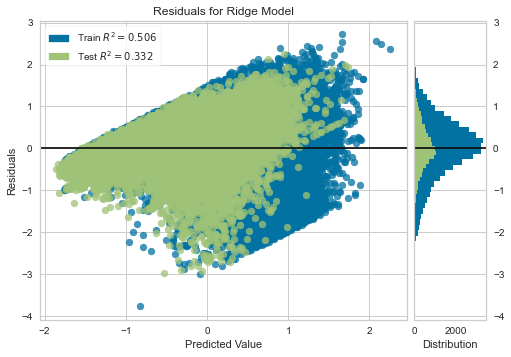

<AxesSubplot:title={'center':'Residuals for Ridge Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [48]:
from yellowbrick.regressor import ResidualsPlot

R_R_chatelet_model_CO2 = Ridge(alpha=1000)
visualizer = ResidualsPlot(R_R_chatelet_model_CO2)

visualizer.fit(X_train_RR, y_train_RR)  # Fit the training data to the visualizer
visualizer.score(X_test_RR, y_test_RR)  # Evaluate the model on the test data
visualizer.show() 

/Users/danaalmanla/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


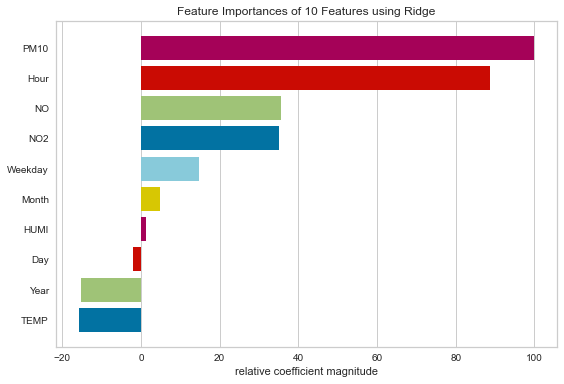

<AxesSubplot:title={'center':'Feature Importances of 10 Features using Ridge'}, xlabel='relative coefficient magnitude'>

In [49]:
from yellowbrick.model_selection import FeatureImportances

model = Ridge(alpha=1000)
viz = FeatureImportances(model)
viz.fit(X_train_RR, y_train_RR)
viz.show()

### A.2- ARMA (autoregression)/forcasting

In [50]:
# for fitting 40k points are taken and the rest for testing
model_arma = ARMA(ratp_chatelet['CO2'][:40000], order=(1,0))
result = model_arma.fit()
print(result.summary())
print("μ={} ,ϕ={}".format(result.params[0],result.params[1]))

                              ARMA Model Results                              
Dep. Variable:                    CO2   No. Observations:                40000
Model:                     ARMA(1, 0)   Log Likelihood              -27382.435
Method:                       css-mle   S.D. of innovations              0.480
Date:                Sun, 31 Jan 2021   AIC                          54770.870
Time:                        12:45:34   BIC                          54796.660
Sample:                             0   HQIC                         54779.033
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1123      0.021      5.424      0.000       0.072       0.153
ar.L1.CO2      0.8841      0.002    378.426      0.000       0.880       0.889
                                    Roots           

/Users/danaalmanla/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


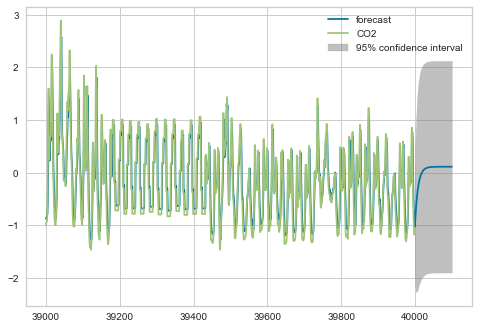

In [51]:
result.plot_predict(start=39000, end=40100)
plt.show()

In [52]:
predicted_values = result.predict(start=40000,end=50353)



In [53]:

rmse = math.sqrt(mean_squared_error(ratp_chatelet['CO2'][40000:50354], predicted_values))
print("root mean squared error = {}".format(rmse))

root mean squared error = 0.9224663534063621


### A.3- ARIMA

Choosing p,d,q:
- since data is statinary --> d= 0
- to determine p (AR terma) --> examine the autocorrelation plot (PACF)
- to determine q --> examine ACF plot

PACF for finding p

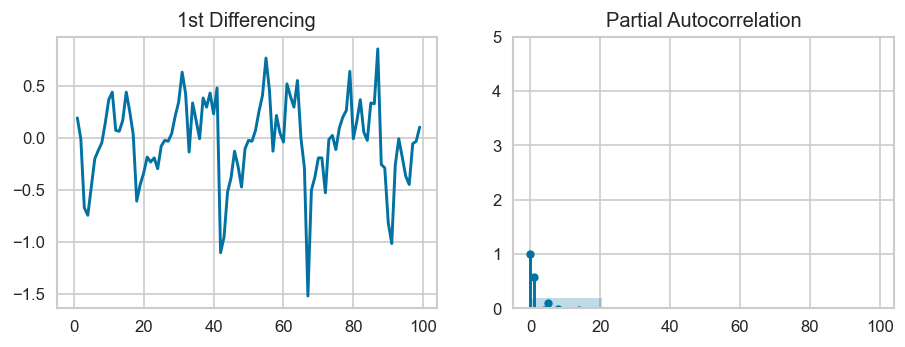

In [54]:

plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(ratp_chatelet['CO2'][0:100].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(ratp_chatelet['CO2'][0:100].diff().dropna(), ax=axes[1])

plt.show()

PACF lag 1 is higher than the significant line --> p =1

ACF plot

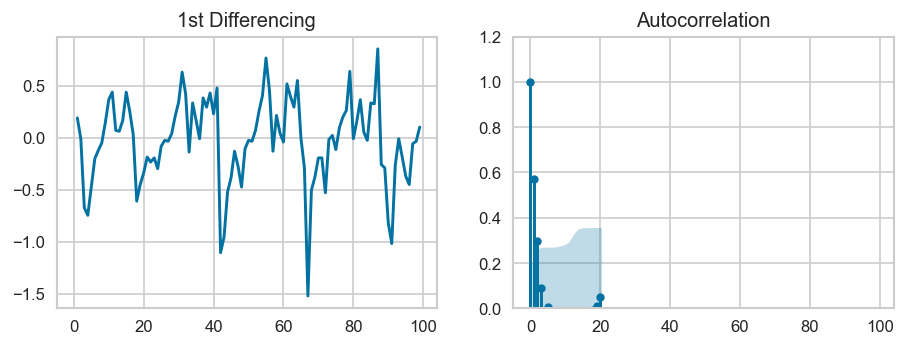

In [55]:

plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(ratp_chatelet['CO2'][0:100].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(ratp_chatelet['CO2'][0:100].diff().dropna(), ax=axes[1])

plt.show()

a value of 1 can work with q

In [58]:

rcParams['figure.figsize'] = 16, 6
model = ARIMA(ratp_chatelet['CO2'][0:40000].diff().iloc[1:].values, order=(1,0,1))
fitted_mod = model.fit()


/Users/danaalmanla/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [59]:
print(fitted_mod.summary())



                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                39998
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -34435.481
Method:                       css-mle   S.D. of innovations              0.572
Date:                Sun, 31 Jan 2021   AIC                          68876.962
Time:                        14:22:39   BIC                          68902.751
Sample:                             1   HQIC                         68885.125
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.355e-06      0.002     -0.002      0.998      -0.004       0.004
ar.L1.D.y     -0.3315      0.005    -70.267      0.000      -0.341      -0.322
                                    Roots           

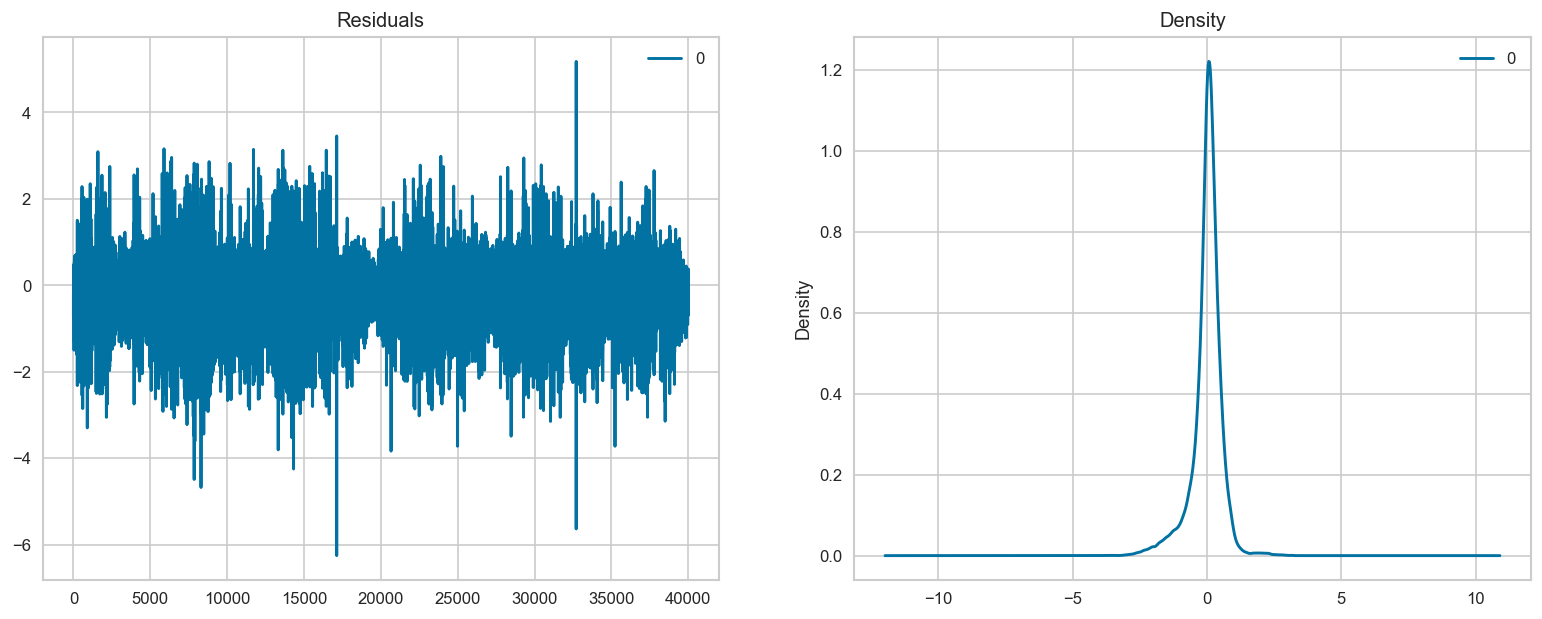

In [60]:
residuals = pd.DataFrame(fitted_mod.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

The residual plot is close to zero and uniform variance.

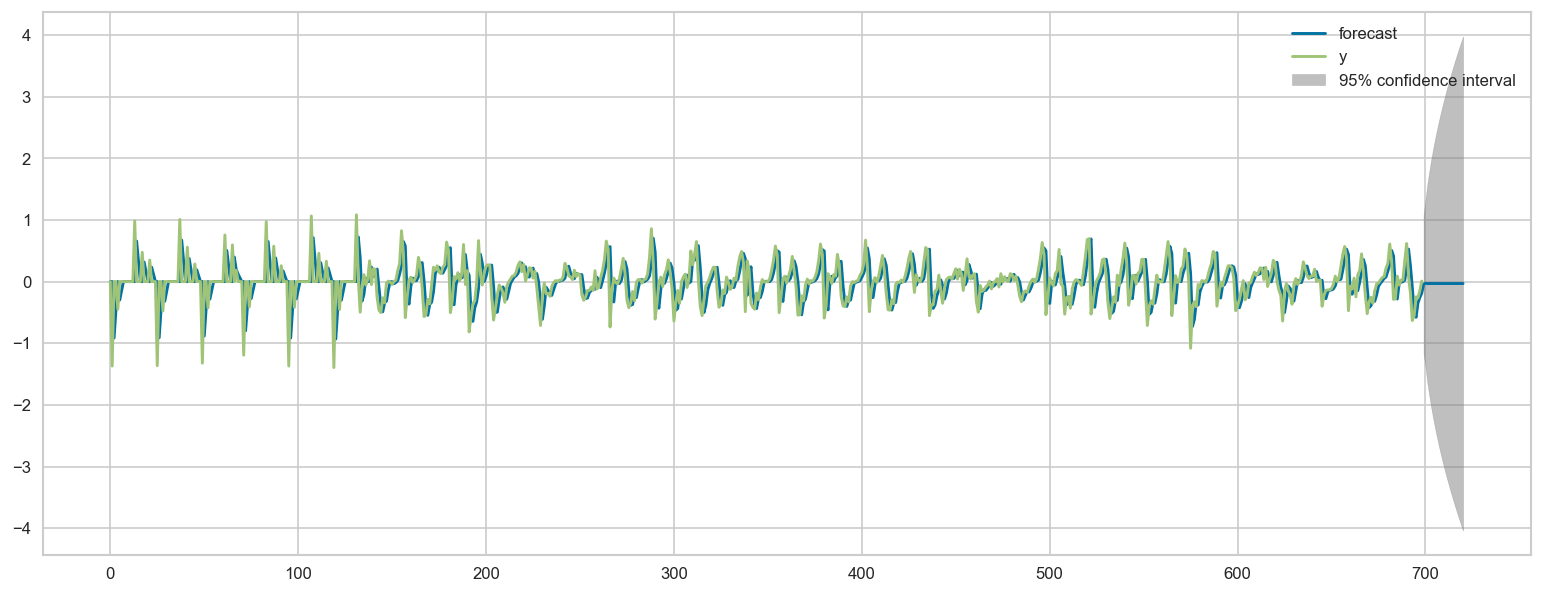

In [61]:
fitted_mod.plot_predict(start=39300, end=40020,dynamic=False)
plt.show()

In [62]:
predicted_values = fitted_mod.predict(start=40000,end=50352)
rmse = math.sqrt(mean_squared_error(ratp_chatelet['CO2'][40000:50354], predicted_values))
print("Root mean squared error = {}.".format(rmse))

Root mean squared error = 0.8612744464930091.
